In [433]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [410]:
# Load the dataset
df = pd.read_csv('weather_data/weather_data.csv', parse_dates=['Date'])


In [411]:
# we have to take one city at a time
df = df.query('City == "Meridian"')
df.head()

,Date,Month,Week,Year,City,Code,Location,State,Avg_Temp,Max_Temp,Min_Temp,Wind_Direction,Wind_Speed,Precipitation
156,2016-03-01,1,3,2016,Meridian,MEI,"Meridian, MS",Mississippi,43,49,36,34,5.56,0.01
471,2016-10-01,1,10,2016,Meridian,MEI,"Meridian, MS",Mississippi,45,53,33,13,5.37,0.10
786,2016-01-17,1,17,2016,Meridian,MEI,"Meridian, MS",Mississippi,44,58,29,22,3.55,0.10
1101,2016-01-24,1,24,2016,Meridian,MEI,"Meridian, MS",Mississippi,42,52,31,17,6.17,1.50
1416,2016-01-31,1,31,2016,Meridian,MEI,"Meridian, MS",Mississippi,50,65,36,20,6.77,1.53


In [412]:
df.set_index('Date', inplace=True)


In [413]:
df.drop(["Month", "Week", "Year", "City", "Code", "Location", "State", "Avg_Temp", "Max_Temp", "Min_Temp", "Wind_Direction", "Wind_Speed"], axis=1, inplace=True)
df.head()

,Precipitation
Date,
2016-03-01,0.01
2016-10-01,0.10
2016-01-17,0.10
2016-01-24,1.50
2016-01-31,1.53


In [414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2016-03-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precipitation  53 non-null     float64
dtypes: float64(1)
memory usage: 848.0 bytes


In [415]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [416]:
train_df.head()

,Precipitation
Date,
2016-03-01,0.01
2016-10-01,0.10
2016-01-17,0.10
2016-01-24,1.50
2016-01-31,1.53


In [417]:
test_df.head()

,Precipitation
Date,
2016-10-23,0.00
2016-10-30,0.00
2016-06-11,0.00
2016-11-13,0.20
2016-11-20,0.01


In [418]:
# Preprocess the data
scaler = MinMaxScaler()

In [420]:
# Scale the numeric columns in your DataFrame
numeric_columns = ['Precipitation']


In [421]:
scaled_train_data = scaler.fit_transform(train_df[numeric_columns])
scaled_test_data = scaler.transform(test_df[numeric_columns])

In [422]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length, -1])  # Target is the last column (Precipitation)
    return np.array(sequences), np.array(targets)

In [423]:
# Define sequence length (number of time steps to look back)
seq_length = 5  # You can adjust this

In [424]:
# Create sequences and targets for training and testing data
train_sequences, train_target = create_sequences(scaled_train_data, seq_length)
test_sequences, test_target = create_sequences(scaled_test_data, seq_length)

In [425]:
train_sequences.shape, train_target.shape

((37, 5, 1), (37,))

In [426]:
test_sequences.shape, test_target.shape

((6, 5, 1), (6,))

In [427]:
# Build the model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, len(numeric_columns))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [428]:
# Train the model
history = model.fit(train_sequences, train_target, epochs=100, batch_size=32, validation_data=(test_sequences, test_target), verbose=2)


Epoch 1/100
2/2 - 1s - loss: 0.0502 - val_loss: 0.0127 - 1s/epoch - 527ms/step
Epoch 2/100
2/2 - 0s - loss: 0.0466 - val_loss: 0.0106 - 52ms/epoch - 26ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0443 - val_loss: 0.0092 - 50ms/epoch - 25ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0429 - val_loss: 0.0085 - 46ms/epoch - 23ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0422 - val_loss: 0.0081 - 38ms/epoch - 19ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0419 - val_loss: 0.0079 - 41ms/epoch - 21ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0417 - val_loss: 0.0077 - 37ms/epoch - 19ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0415 - val_loss: 0.0074 - 40ms/epoch - 20ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0415 - val_loss: 0.0071 - 42ms/epoch - 21ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0413 - val_loss: 0.0070 - 39ms/epoch - 19ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0414 - val_loss: 0.0070 - 42ms/epoch - 21ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0420 - val_loss: 0.0071 - 38ms/epoch - 19ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0423 -

In [429]:
# Make predictions on the test set
test_predictions = model.predict(test_sequences)

1/1 [==============================] - 0s 189ms/step


In [430]:
print(f"{scaled_test_data}")
print(f"{test_predictions}")

[[0.        ]
 [0.        ]
 [0.        ]
 [0.03322259]
 [0.00166113]
 [0.00166113]
 [0.11627907]
 [0.12126246]
 [0.22093023]
 [0.        ]
 [0.18936877]]
[[0.11495049]
 [0.11444807]
 [0.1259818 ]
 [0.1348385 ]
 [0.15058431]
 [0.14037865]]


In [431]:
# Inverse transform the predictions and target to the original scale
test_predictions = scaler.inverse_transform(test_predictions)  # Exclude Precipitation column
test_target_original = scaler.inverse_transform(test_target.reshape(-1, 1))


In [434]:
# Calculate RMSE on the original scale
rmse = np.sqrt(mean_squared_error(test_target_original, test_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.5233567222868267


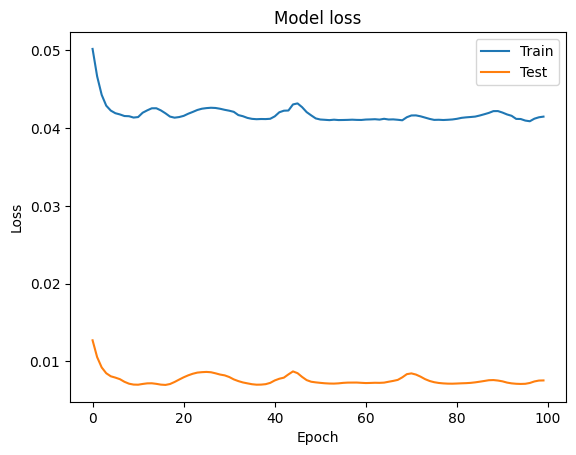

In [435]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()